In [52]:
import COFE.analyse
import COFE.scpca
import COFE.plot
import numpy as np
import anndata as ad
import pandas as pd
import PCA_func as pca
import matplotlib.pyplot as mp

### Step 1: Importing the Dataset

In [180]:
#Open dataset
path_1 = '/Users/maksimsgolubovics/Python_VScode/Studienprojekt'
path = path_1+'/mouse_liver_noGH/mice.h5ad'
adata = ad.read_h5ad(path)

#Without batch effects
df = adata.obsm['centered_study']
#With batch effects
log_batcheffect = adata.layers['log_trasformed']
df_log_batcheffect = pd.DataFrame(data=log_batcheffect, columns=adata.var.index, index=adata.obs.index)
#Look at data
df_log_batcheffect

Name,ENSMUSG00000087193,ENSMUSG00000039545,ENSMUSG00000085599,ENSMUSG00000084908,ENSMUSG00000086484,ENSMUSG00000085087,ENSMUSG00000085224,ENSMUSG00000085491,ENSMUSG00000086994,ENSMUSG00000086669,...,ENSMUSG00000073482,ENSMUSG00000092496,ENSMUST00000177819,ENSMUSG00000083580,ENSMUSG00000085891,ENSMUSG00000063488,ENSMUST00000058336,ENSMUSG00000025754,ENSMUSG00000092464,ENSMUST00000053062
GSM2046160,-0.830161,-0.844585,-0.944060,-1.000000,-0.931391,-0.545788,-1.0,-1.0,-1.00000,-1.000000,...,-1.000000,-1.0,-1.0,-1.000000,-0.887110,0.445732,-1.0,-1.0,-1.000000,-0.622461
GSM2046184,-1.000000,-0.930798,-0.948273,-1.000000,-1.000000,-0.487130,-1.0,-1.0,-1.00000,-0.734124,...,-1.000000,-1.0,-1.0,-0.931473,-0.880454,0.362831,-1.0,-1.0,-1.000000,-0.941779
GSM2046157,-0.951962,-0.950224,-0.888539,-1.000000,-1.000000,-0.460668,-1.0,-1.0,-1.00000,-1.000000,...,-0.658170,-1.0,-1.0,-1.000000,-1.000000,0.425347,-1.0,-1.0,-0.938295,-1.000000
GSM2046183,-0.857623,-0.868535,-0.949044,-1.000000,-1.000000,-0.512794,-1.0,-1.0,-1.00000,-1.000000,...,-0.567566,-1.0,-1.0,-1.000000,-0.958931,0.411055,-1.0,-1.0,-1.000000,-0.708336
GSM2046155,-1.000000,-0.900192,-0.744648,-1.000000,-1.000000,-0.589398,-1.0,-1.0,-1.00000,-0.142733,...,-0.629750,-1.0,-1.0,-1.000000,-0.968810,0.448777,-1.0,-1.0,-0.951236,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM6610738,-1.000000,-0.868009,-0.501261,-1.000000,-1.000000,-1.000000,-1.0,-1.0,-0.63686,-0.380666,...,-1.000000,-1.0,-1.0,-1.000000,-0.908959,0.291353,-1.0,-1.0,-1.000000,-1.000000
GSM6610724,-1.000000,-0.747234,-0.522675,-1.000000,-1.000000,-0.042687,-1.0,-1.0,-1.00000,-1.000000,...,-0.677206,-1.0,-1.0,-1.000000,-0.769199,0.257472,-1.0,-1.0,-1.000000,-1.000000
GSM6610752,-1.000000,-0.843408,-0.483154,-1.000000,-1.000000,-0.261752,-1.0,-1.0,-1.00000,-0.296092,...,-1.000000,-1.0,-1.0,-1.000000,-0.811935,0.448722,-1.0,-1.0,-1.000000,-1.000000
GSM6610726,-0.933827,-0.842135,-0.415591,-0.891259,-1.000000,0.108785,-1.0,-1.0,-1.00000,-0.031717,...,-0.424117,-1.0,-1.0,-1.000000,-0.831096,0.247423,-1.0,-1.0,-1.000000,-1.000000


### Step 2: Prepare the dataset

In [ ]:
#Subset the dataset WITHOUT batcheffect for 5 studies with ca. 100 samples
study = adata.obs[adata.obs['study'].isin(['Abe22', 'Acosta-Rodríguez22A', 'Acosta-Rodríguez22B', 'Astafev23','Yang16A'])]['study']
X_test =df.loc[study.index]

#Substract X_test data to generate X_train
X_train = df.drop(index=X_test.index)

In [190]:
#Subset the dataset WITH batcheffect for 5 studies with ca. 100 samples
study = adata.obs[adata.obs['study'].isin(['Abe22', 'Acosta-Rodríguez22A', 'Acosta-Rodríguez22B', 'Astafev23','Yang16A'])]['study']
X_test = df_log_batcheffect.loc[study.index]

#Substract X_test data to generate X_train
X_train = df_log_batcheffect.drop(index=X_test.index)

In [191]:
true_time_train = adata.obs['time'].drop(index=X_test.index)
true_time_test =adata.obs['time'].loc[study.index]

### Step 3: Apply preprocess

In [192]:
X_train_, X_test_, features_, features_std_ = COFE.analyse.preprocess_data(X_train.to_numpy(), X_test.to_numpy(), 
                                                                           features=X_train.columns, feature_dim='col',
                                                                           mean_threshold= 0.5,
                                                                           scaling_threshold=7.3)
X_train_.shape

(995, 7436)

### Step 4: Cross validation

In [193]:
s_choices = np.linspace(1, 40, 15)
cv = COFE.analyse.cross_validate(X_train_, s_choices, features=features_, K=5, ncores=-1)

### Step 5: Predict and plot

#### 101 samples

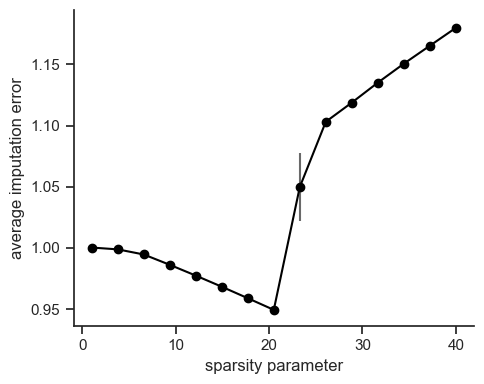

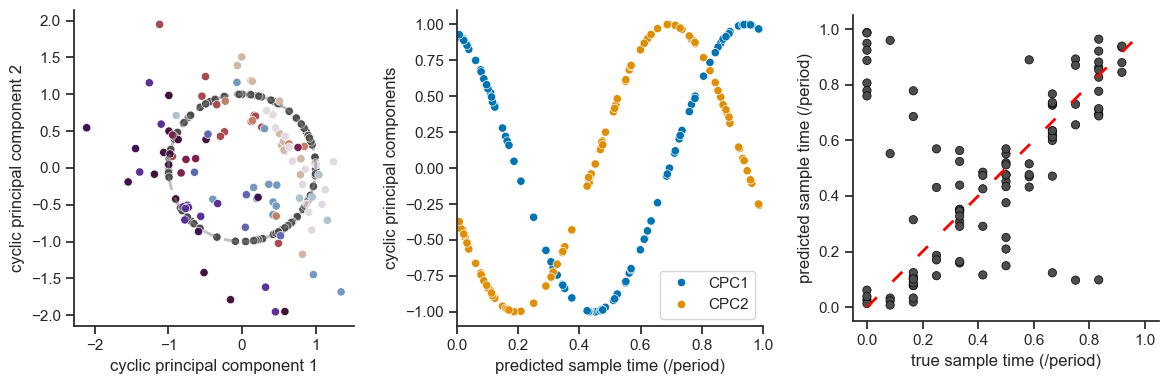

In [113]:
train_results_mouse = COFE.analyse.predict_time(X_train_, cv, true_times=true_time.to_numpy())
COFE.plot.plot_cv_run(train_results_mouse, figsize=(5,4))
COFE.plot.plot_circular_ordering(train_results_mouse, time=true_time.to_numpy(), X=X_train_, figsize=(12, 4))

#### 995 Samples

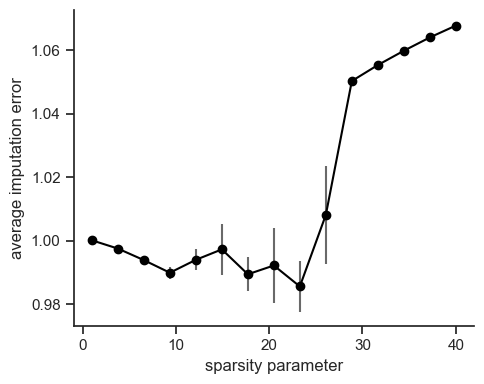

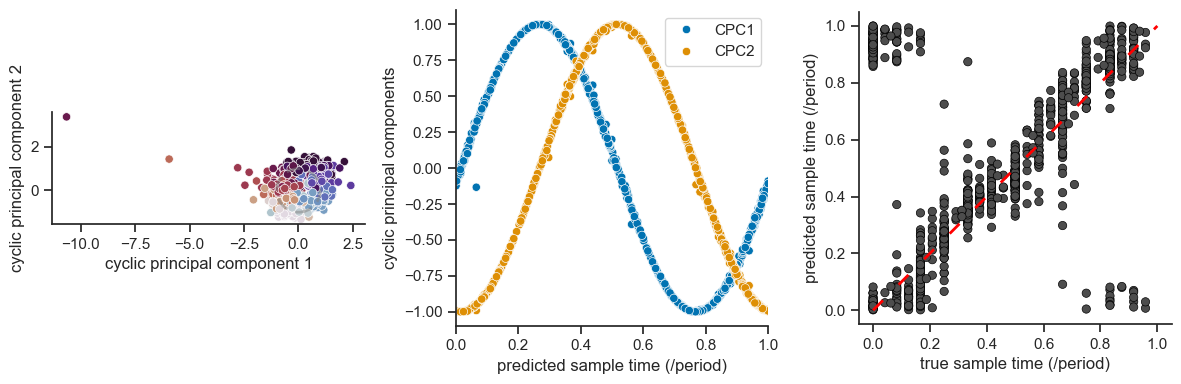

In [133]:
train_results_mouse = COFE.analyse.predict_time(X_train_, cv, true_times=true_time_train.to_numpy())
COFE.plot.plot_cv_run(train_results_mouse, figsize=(5,4))
COFE.plot.plot_circular_ordering(train_results_mouse, time=true_time_train.to_numpy(), X=X_train_, figsize=(12, 4))

#### 995 Samples with batch effect

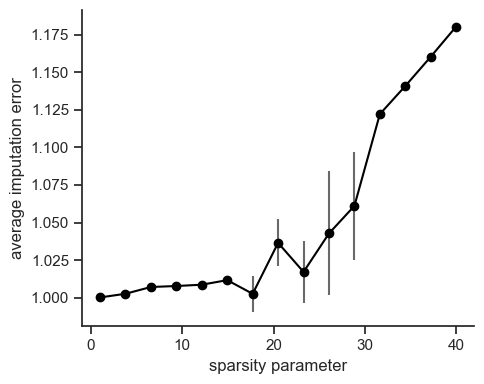

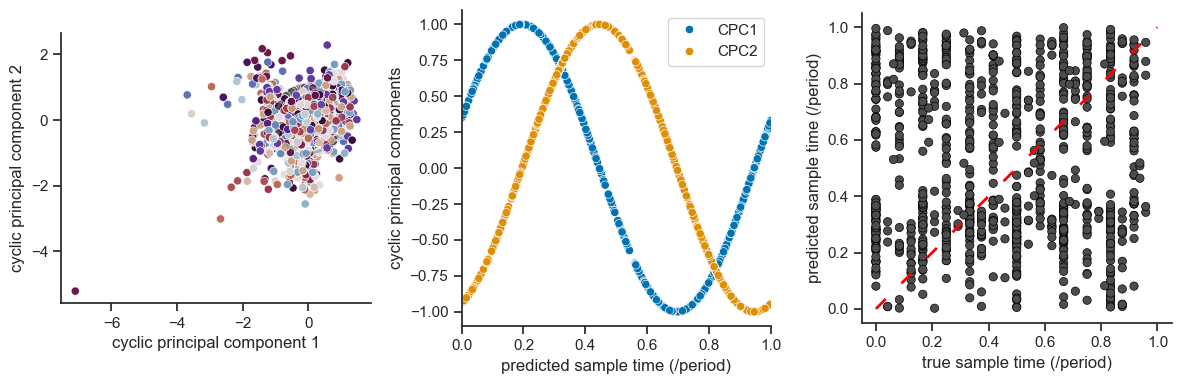

In [194]:
train_results_mouse = COFE.analyse.predict_time(X_train_, cv, true_times=true_time_train.to_numpy())
COFE.plot.plot_cv_run(train_results_mouse, figsize=(5,4))
COFE.plot.plot_circular_ordering(train_results_mouse, time=true_time_train.to_numpy(), X=X_train_, figsize=(12, 4))

#### Results of the test data

In [161]:
test_results_mouse = COFE.analyse.predict_time(X_test_, cv, true_times=true_time_test.to_numpy())
test_results_mouse['phase']



array([0.09071469, 0.51704209, 0.80691848, 0.96997454, 0.30272283,
       0.89772031, 0.8914059 , 0.16687754, 0.86772475, 0.7992654 ,
       0.16938282, 0.02229226, 0.59662851, 0.80183184, 0.37614776,
       0.59936887, 0.02752918, 0.38318928, 0.11397478, 0.38274631,
       0.58760272, 0.17056386, 0.79987983, 0.4420461 , 0.65535447,
       0.38132196, 0.35480078, 0.66171573, 0.71047675, 0.13233887,
       0.53250527, 0.11251176, 0.43651821, 0.05549093, 0.93550536,
       0.08030805, 0.35849559, 0.79360613, 0.89955161, 0.01414593,
       0.9352095 , 0.47598217, 0.91531418, 0.33818238, 0.90159871,
       0.85585833, 0.28980158, 0.6883878 , 0.67828033, 0.96766958,
       0.34354975, 0.30379433, 0.26611288, 0.90581742, 0.02489082,
       0.48254305, 0.15266137, 0.89747493, 0.50949367, 0.02305787,
       0.52256251, 0.82604763, 0.96979027, 0.13604619, 0.88829626,
       0.25809295, 0.67889561, 0.44879164, 0.8047538 , 0.37919925,
       0.81279017, 0.67543658, 0.21654853, 0.53759245, 0.84049

### Other tests

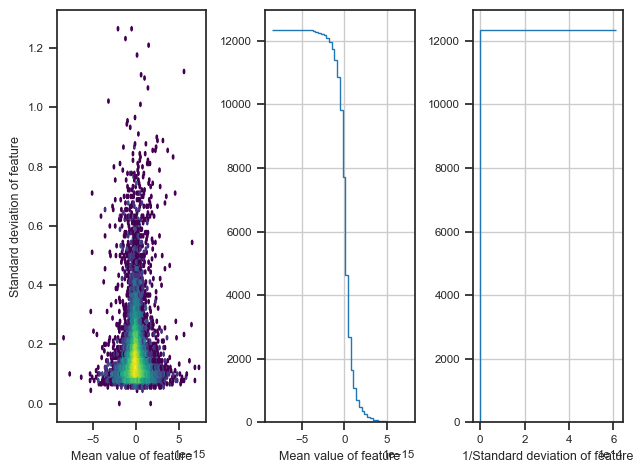

In [91]:
COFE.plot.plot_diagnostics(X_train, feature_dim='col')


#### MAPE

In [148]:
test_results_mouse["MAPE"]*24

np.float64(1.196542664376964)